### Author: **Dimitrios Yfantidis (3938)**
_Written in Python ver. 3.10.7_

In [1]:
# Initialization
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(elapsed: 3.9s)

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 mutually exclusive classes, with 6000 images per class.  
There are 50000 training images and 10000 test images.  

It is loaded using the `cifar10.load_data()` method, imported from `keras` library.

In [2]:
# Load the CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

assert np.shape(X_train) == (50000, 32, 32, 3)
assert np.shape(Y_train) == (50000, 1)
assert np.shape(X_test) == (10000, 32, 32, 3)
assert np.shape(Y_test) == (10000, 1)

# Transform data samples to 3072 byte vectors (with channels ordered as Red, Green, Blue)
X_train = np.reshape(X_train.transpose(0,3,1,2), (50000, 32*32*3))
Y_train = np.reshape(Y_train, (50000,))
X_test = np.reshape(X_test.transpose(0,3,1,2), (10000, 32*32*3))
Y_test = np.reshape(Y_test, (10000,))

N_TRAIN = 50000
N_TEST = 10000

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(elapsed: 0.5s)

We test the validity of the dataset and `class_names` list by printing a 5x5 grid of random images.

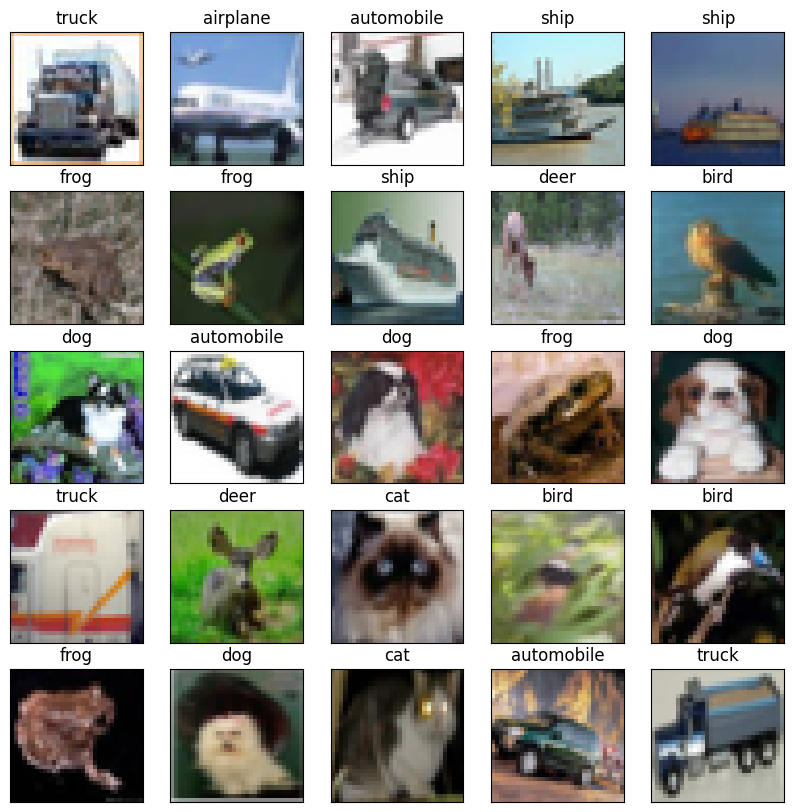

In [3]:
# Sample images are selected from the first.
images = np.copy(X_train)
labels = np.copy(Y_train)
# Format the data accordingly.
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

# 25 Sample images will appear in a square grid.
rows, columns = 5, 5
# List with 25 random image indices.
image_indices = random.sample(range(len(images)), rows * columns)
# Their corresponding data. 
images = [images[i] for i in image_indices]
# Their corresponding labels. 
labels = [labels[i] for i in image_indices]

# Define figure
fig=plt.figure(figsize=(10, 10))
# Visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}".format(class_names[labels[i-1]]))
plt.show()

For the classification of the images, a **Multilayer Perceptron** model was implemented using only NumPy.  
The classifier's implementation is the `FullyConnectedClassifier` class, situated in the `NeuralNetwork` module.

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from NeuralNetwork import FullyConnectedClassifier

### Multi-Layer Perceptron Implementation

<img src="./pictures/nnet.jpg" alt="drawing" width="500"/>

This segment will explain the implementation in `NeuralNetwork.FullyConnectedClassifier`.

Below the symbolisms of the variables that constitute the Neural Netwok are listed, as well as their logic and their relationships to each other:
* $\vec{x} = (x_1, x_2, ..., x_n)$: Input vector of dimensionality $n$.
* $\vec{y} = (y_1, y_2, ..., y_m)$: Output vector of dimensionality $m$.  
	In cases of One-Hot encoding the output is $\argmax_i y_i$.
* $\vec{d} = (d_1, d_2, ..., d_m)$: Ground-truth output vector of dimensionality $m$.  
	In case of classification, $d$ is the One-Hot encoded output of the real target class.
* $l \in \mathbb{N}$: The number of hidden layers.
* $k_s \in \mathbb{N}$: Number of neurons in the $s$-th layer.
* $\mathbf{F} = [f_1, f_2, ..., f_{l+1}]:$ List of $l+1$ activation functions, one for each layer.
* $f_s: \mathbb{R} \rightarrow \mathbb{R}$: Activation function of the $s$-th layer. For vector $\vec{u} \in \mathbb{R}^k$:  
	$ \vec{u} = 
	\begin{bmatrix}
	u_1 \\
	u_2 \\
	... \\
	u_k 
	\end{bmatrix}
	\Rightarrow f_s(\vec{u}) = 
	\begin{bmatrix}
	f_s(u_1) \\
	f_s(u_2) \\
	...    \\
	f_s(u_k)
	\end{bmatrix}
	$  
* $\mathbf{W} = [W^{(1)}, W^{(2)}, ..., W^{(l+1)}]$: List of $l+1$ weight matrices, one for each layer.  
	In a given layer, $s$, the previous $i$-th neuron, $N^{(s-1)}_{i}$ affects the next $j$-th neuron $N^{(s)}_{j}$ with weight $w^{(s)}_{ji}$.  
	This relationship between neurons from one layer to another is described in the matrix $W^{(s)}$.  
	Layer $s$ has $k_s$ neurons, while $s-1$ has $k_{s-1}$ neurons, thus $W^{(s)}$ has dimensions $k_s \times k_{s-1}$.

* $\mathbf{B} = [\vec{b}^{(1)}, \vec{b}^{(2)}, ..., \vec{b}^{(l+1)}]$: List of $l+1$ bias vectors. $b^{(s)}_i$ is the bias of the $i$-th neuron in layer $s$.	 
	
* $\mathbf{V} = [\vec{v}^{(0)}, \vec{v}^{(1)}, ..., \vec{v}^{(l+1)}]$: 
	List of $l+2$ layer value vectors, $v_i^{(s)}$ is the output of the $i$-th neuron in layer $s$.  
	Also, $\vec{v}^{(0)} = \vec{x}$ and $\vec{v}^{\,(l+1)} = \vec{v}^{\,(out)} = \vec{y}$.  

	$\vec{v}^{\,(s)} = f(\vec{u}^{\,(s)} + \vec{b}^{(s)}) = f(W^{(s)} \cdot \vec{v}^{\,(s-1)} + \vec{b}^{(s)})$  
	
	$\left.
	\begin{array}{ll}
       W^{(s)}:k_s \times k_{s-1} \\
      \vec{v}^{\,(s-1)}: k_{s-1} \times 1\\
	\end{array} 
	\right\}
	\Rightarrow \vec{u}^{\,(s)}: k_s \times 1
	$  
	$
	\left.
	\begin{array}{ll}
      \vec{u}^{\,(s)}: k_s \times 1 \\
      \vec{b}^{\,(s)}: k_s \times 1\\
	\end{array}\right\} \;\Rightarrow \;\vec{v}^{\,(s)}: k_s \times 1
	$  
* $\mathbf{U} = [\vec{u}^{(1)}, \vec{u}^{(2)}, ..., \vec{u}^{(l+1)}]$: List of $l+1$ weighted sum vectors, i.e. $u^{\,(s)}_{i}$ is the weighted sum of the $i$-th neuron in layer $s$.  

* $\boldsymbol{\delta} = [\vec{\delta}^{(1)}, \vec{\delta}^{(2)}, ..., \vec{\delta}^{(l+1)}]$: List of $l+1$ gradient vectors. $\delta^{(s)}_i$ represents the gradient of the $i$-th neuron in layer $s$.

### Constructor
1. `num_inputs`: input dimensionality, $n$  
2. `num_outputs`: output dimensionality, $m$  
3. `out_func`: The activation function of the output layer, $f^{(l+1)}$  
4. `hidden_layers`: List of (No. neurons, activation function) tuple in each hidden layer, $[(k_1, f_1), (k_2, f_2), ..., (k_l, f_l)]$  
5. `learning_rate`: The network's learning rate, $\eta$  
6. `error_func`: Either `"square-error"` or `"cross-entropy"`. The network uses the corresponding loss function.

### Forward Pass
* Initialize $\vec{v}^{(0)} \coloneqq \vec{x}$  
* For $s \coloneqq 1, 2, ..., l+1$:
    1. $\vec{u}^{(s)} \coloneqq W^{(s)} \times \vec{v}^{(s-1)}$  
    2. $\vec{v}^{(s)} \coloneqq f_s(\vec{u}^{(s)} + \vec{b}^{(s)})$


### Back Propagation
* Initialize $\vec{y} \coloneqq \vec{v}^{(l+1)}$  
* Compute error, $\vec{e} \coloneqq loss(\vec{d},\, \vec{y})$
* Compute output gradient, $\vec{\delta}^{(l+1)} \coloneqq \vec{e} \odot f'_{l+1}(\vec{u}^{(l+1)} + \vec{b}^{(l+1)})$  
    ($\odot$ denotes element-wise multiplication of vectors/matrices)  
* For $s \coloneqq l, l-1, ..., 1$:  
    1. $\vec{\delta}^{(s)} \coloneqq [(W^{(s+1)})^T \times \vec{\delta}^{(s+1)}] \odot f'_s(\vec{u}^{(s)} + \vec{b}^{(s)})$

### Weight Update
* For $s \coloneqq 1, 2, ..., l+1$:
    1. $W^{(s)} \coloneqq W^{(s)} - \eta[\vec{\delta}^{(s)} \times (\vec{v}^{(s-1)})^T]$
    2. $\vec{b}^{(s)} \coloneqq \vec{b}^{(s)} - \eta \vec{\delta}^{(s)}$

Firstly, the images have to be reduced to their principal components using **PCA**.  
This helps the model train faster and filters the excess noise in the images.

In [5]:
N_COMPONENTS = 128
pca = PCA(n_components=N_COMPONENTS).fit(X_train)

# The dataset is reduced from 3072 to 128 dimensions
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

# Each sample is normalized from [0, 255] to [0, 1] avoid the vanishing gradient of the activation functions.
X_train_reduced = Normalizer('max').fit_transform(X_train_reduced)
X_test_reduced = Normalizer('max').fit_transform(X_test_reduced)

(elapsed: 13.0s)

The Following classifier uses the instant squared error loss function:
$$\mathcal{E} = \frac{1}{2}\sum_{i=1}^{m}e_i^{2} = \frac{1}{2}\sum_{i=1}^{m}(d_i - y_i)^{2}$$
Thus, **Stohastic Gradient Descent** is perofrmed using:
$$\frac{\partial \mathcal{E}}{\partial y_i} = \frac{\partial \mathcal{E}}{\partial e_i} \frac{\partial \mathcal{e_i}}{\partial y_i} = 
-\sum_{i=1}^{m}e_i = \sum_{i=1}^{m}(y_i - d_i)$$

In [6]:
clf = FullyConnectedClassifier(
    num_inputs=N_COMPONENTS, 
    num_outputs=10, 
    out_func="sigmoid", 
    hidden_layers=[(128, "sigmoid"), (64, "sigmoid")], 
    learning_rate=0.001, 
    error_func="square-error"
)
print(clf.diagnostics())

------------------ [Classifier Diagnostics] ------------------
> Learning Rate: η = 0.001
> Activation Function (Output): sigmoid
> Error Function: square-error
> Input Dim.: 128
> Output Dim.: 10
> Hidden Layers: (2 layers)
	* Neurons: 128, Activation: sigmoid
	* Neurons: 64, Activation: sigmoid
> Value Dim.:
	* v^(0): (128, 1)
	* v^(1): (128, 1)
	* v^(2): (64, 1)
	* v^(3): (10, 1)
> Weight & Bias Dim.:
	* W^(1): (128, 128), b^(1): (128, 1)
	* W^(2): (64, 128), b^(2): (64, 1)
	* W^(3): (10, 64), b^(3): (10, 1)
--------------------------------------------------------------



The classifier achieved **34.9%** accuracy after 3+ hours of training for 1000 epochs.  
Note: _training can be paused at any point by stopping the cells exuction, without losing any training progress._

In [ ]:
# The logged accuracy is in regards to the test set which is never involved in the training.
clf.fit(X_train_reduced, Y_train, (X_test_reduced, Y_test), n_epochs=1000)

Output of previous cell was:
```
...
Finished epoch No.989, Elapsed Time: 11.00sec, Accuracy: 34.90%
Finished epoch No.990, Elapsed Time: 11.04sec, Accuracy: 34.90%
Finished epoch No.991, Elapsed Time: 10.98sec, Accuracy: 34.91%
Finished epoch No.992, Elapsed Time: 11.03sec, Accuracy: 34.91%
Finished epoch No.993, Elapsed Time: 11.01sec, Accuracy: 34.92%
Finished epoch No.994, Elapsed Time: 11.00sec, Accuracy: 34.91%
Finished epoch No.995, Elapsed Time: 10.99sec, Accuracy: 34.90%
Finished epoch No.996, Elapsed Time: 11.00sec, Accuracy: 34.90%
Finished epoch No.997, Elapsed Time: 11.02sec, Accuracy: 34.90%
Finished epoch No.998, Elapsed Time: 11.02sec, Accuracy: 34.92%
Finished epoch No.999, Elapsed Time: 11.01sec, Accuracy: 34.92%
Finished epoch No.1000, Elapsed Time: 10.97sec, Accuracy: 34.90%
```
(elapsed: 3h, 8m, 46.2s)

As an experiment the softmax function was used for the output neurons.  
The softmax function has a steeper gradient towards the middle which should probably improve results during back propagation.

In [ ]:
clf2 = FullyConnectedClassifier(
    num_inputs=N_COMPONENTS, 
    num_outputs=10, 
    out_func="softmax", 
    hidden_layers=[(128, "sigmoid"), (64, "sigmoid")], 
    learning_rate=0.002, 
    error_func="square-error"
)
clf2.fit(X_train_reduced, Y_train, (X_test_reduced, Y_test), n_epochs=1000)

Output of previous cell:
```
...
Finished epoch No.15, Elapsed Time: 12.36sec, Accuracy: 28.73%
Finished epoch No.16, Elapsed Time: 12.34sec, Accuracy: 28.82%
Finished epoch No.17, Elapsed Time: 12.37sec, Accuracy: 28.71%
Finished epoch No.18, Elapsed Time: 12.37sec, Accuracy: 28.87%
Finished epoch No.19, Elapsed Time: 12.36sec, Accuracy: 28.93%
Finished epoch No.20, Elapsed Time: 12.53sec, Accuracy: 28.98%
Interrupt: Finished training during epoch No.21
```
(elapsed: 4m, 36s)

It is evident that accuracy plateaus at some point in time.  
The number of principal components in hopes that more information will help delay the accuracy's stagnation (e.g. at 60% accuracy instead of 30~40%). 

In [9]:
N_COMPONENTS = 256
pca = PCA(n_components=N_COMPONENTS).fit(X_train)

# The dataset is reduced from 3072 to 128 dimensions
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

# Each sample is normalized from [0, 255] to [0, 1] avoid the vanishing gradient of the activation functions.
X_train_reduced = Normalizer('max').fit_transform(X_train_reduced)
X_test_reduced = Normalizer('max').fit_transform(X_test_reduced)

The modified model which corresponds to the modified dataset moves slightly faster but still reaches **36.13% accuracy** after 253 epochs.  
That is equivalent to an hour of training.

In [ ]:
clf3 = FullyConnectedClassifier(
    num_inputs=N_COMPONENTS, 
    num_outputs=10, 
    out_func="softmax", 
    hidden_layers=[(128, "sigmoid"), (64, "sigmoid")], 
    learning_rate=0.002, 
    error_func="square-error"
)
clf3.fit(X_train_reduced, Y_train, (X_test_reduced, Y_test), n_epochs=1000)

Output of the previous cell towards the end was:
```
...
Finished epoch No.242, Elapsed Time: 14.19sec, Accuracy: 36.30%
Finished epoch No.243, Elapsed Time: 14.17sec, Accuracy: 36.32%
Finished epoch No.244, Elapsed Time: 14.20sec, Accuracy: 36.29%
Finished epoch No.245, Elapsed Time: 14.12sec, Accuracy: 36.27%
Finished epoch No.246, Elapsed Time: 14.24sec, Accuracy: 36.29%
Finished epoch No.247, Elapsed Time: 14.46sec, Accuracy: 36.29%
Finished epoch No.248, Elapsed Time: 14.31sec, Accuracy: 36.31%
Finished epoch No.249, Elapsed Time: 14.10sec, Accuracy: 36.33%
Finished epoch No.250, Elapsed Time: 14.40sec, Accuracy: 36.27%
Finished epoch No.251, Elapsed Time: 14.05sec, Accuracy: 36.23%
Finished epoch No.252, Elapsed Time: 14.04sec, Accuracy: 36.20%
Finished epoch No.253, Elapsed Time: 14.10sec, Accuracy: 36.13%
Interrupt: Finished training during epoch No.254
```
Towards the end, ccuracy fluctuates between 36.27% and 36.33% but eventually plumets to 36.13%.  
This, obviously, demonstrates the neural network's difficulty exceeding the **36~37%** accuracy area.

The following measures were taken to increase accuracy:
* An extra hidden layer was appended at the front of the network with 256 neurons.
* The learning rate was reduced from `0.002` to `0.0005`
* The cost function was changed to **cross-entropy loss**: 
    $$\mathcal{E} = -\sum_{i=1}^{10}[d_i log_{2}(y_i) + (1 - d_i) log_{2}(1 - y_i)]$$
    Thus, Stohastic Gradient Descent is performed using:
    $$\frac{\partial \mathcal{E}}{\partial y_i} = 
    -\sum_{i=1}^{10}\left[d_i \frac{1}{y_i} - (1 - d_i) \frac{1}{1 - y_i}\right] = 
    \sum_{i=1}^{10}\left(-\frac{d_i}{y_i} + \frac{1 - d_i}{1 - y_i}\right)$$

In [ ]:
clf4 = FullyConnectedClassifier(
    num_inputs=N_COMPONENTS, 
    num_outputs=10, 
    out_func="softmax", 
    hidden_layers=[(256, "sigmoid"), (128, "sigmoid"), (64, "sigmoid")], 
    learning_rate=0.0005, 
    error_func="cross-entropy"
)
clf4.fit(X_train_reduced, Y_train, (X_test_reduced, Y_test), n_epochs=1000)

Output of previous cell was:
```
...
Finished epoch No.353, Elapsed Time: 29.92sec, Accuracy: 31.32%
Finished epoch No.354, Elapsed Time: 29.96sec, Accuracy: 31.29%
Finished epoch No.355, Elapsed Time: 29.89sec, Accuracy: 31.32%
Finished epoch No.356, Elapsed Time: 29.98sec, Accuracy: 31.35%
Finished epoch No.357, Elapsed Time: 29.98sec, Accuracy: 31.34%
Finished epoch No.358, Elapsed Time: 29.90sec, Accuracy: 31.36%
Finished epoch No.359, Elapsed Time: 29.93sec, Accuracy: 31.36%
Finished epoch No.360, Elapsed Time: 29.92sec, Accuracy: 31.42%
Finished epoch No.361, Elapsed Time: 29.94sec, Accuracy: 31.38%
Finished epoch No.362, Elapsed Time: 29.89sec, Accuracy: 31.34%
Finished epoch No.363, Elapsed Time: 29.95sec, Accuracy: 31.34%
Finished epoch No.364, Elapsed Time: 29.86sec, Accuracy: 31.33%
Interrupt: Finished training during epoch No.365
```
(elapsed: 3h, 18m, 41.6s)

For `sklearn.KNearestNeighbors`, 50 components were the best, thus we will reduce `N_COMPONENTS` to somewhere near that.

In [9]:
N_COMPONENTS = 64
pca = PCA(n_components=N_COMPONENTS).fit(X_train)

# The dataset is reduced from 3072 to 128 dimensions
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

# Each sample is normalized from [0, 255] to [0, 1] avoid the vanishing gradient of the activation functions.
X_train_reduced = Normalizer('max').fit_transform(X_train_reduced)
X_test_reduced = Normalizer('max').fit_transform(X_test_reduced)

(elapsed: 7.8s)

In [ ]:
clf5 = FullyConnectedClassifier(
    num_inputs=N_COMPONENTS, 
    num_outputs=10, 
    out_func="softmax", 
    hidden_layers=[(128, "sigmoid"), (64, "sigmoid")], 
    learning_rate=0.001, 
    error_func="cross-entropy"
)
clf5.fit(X_train_reduced, Y_train, (X_test_reduced, Y_test), n_epochs=1000)

Output of the previous cell was:

```
Finished epoch No.331, Elapsed Time: 6.48sec, Accuracy: 38.00%
Finished epoch No.332, Elapsed Time: 6.52sec, Accuracy: 37.99%
Finished epoch No.333, Elapsed Time: 6.55sec, Accuracy: 37.99%
Finished epoch No.334, Elapsed Time: 6.51sec, Accuracy: 37.98%
Finished epoch No.335, Elapsed Time: 6.60sec, Accuracy: 37.98%
Finished epoch No.336, Elapsed Time: 6.51sec, Accuracy: 37.98%
Finished epoch No.337, Elapsed Time: 6.49sec, Accuracy: 37.95%
Finished epoch No.338, Elapsed Time: 6.51sec, Accuracy: 37.92%
Finished epoch No.339, Elapsed Time: 6.52sec, Accuracy: 37.94%
Finished epoch No.340, Elapsed Time: 6.58sec, Accuracy: 37.93%
Finished epoch No.341, Elapsed Time: 6.58sec, Accuracy: 37.91%
Finished epoch No.342, Elapsed Time: 6.54sec, Accuracy: 37.90%
Finished epoch No.343, Elapsed Time: 6.50sec, Accuracy: 37.91%
Finished epoch No.344, Elapsed Time: 6.53sec, Accuracy: 37.88%
Finished epoch No.345, Elapsed Time: 6.44sec, Accuracy: 37.87%
Interrupt: Finished training during epoch No.346
```
(elapsed: 39m, 54s)

The previous classifier seems to have the best accuracy with substantially less training time.   
Thus, it was saved in the file `clf_64_128_64.pickle` using the `pickle` module.  
It can be retrieved by executing the following cell:

In [7]:
import pickle

with open('./stored models/clf_64_128_64.pickle', 'rb') as pickle_file:
    clf6 = pickle.load(file=pickle_file)

### Results
Below we can see how every sample was classified using a confusion matrix

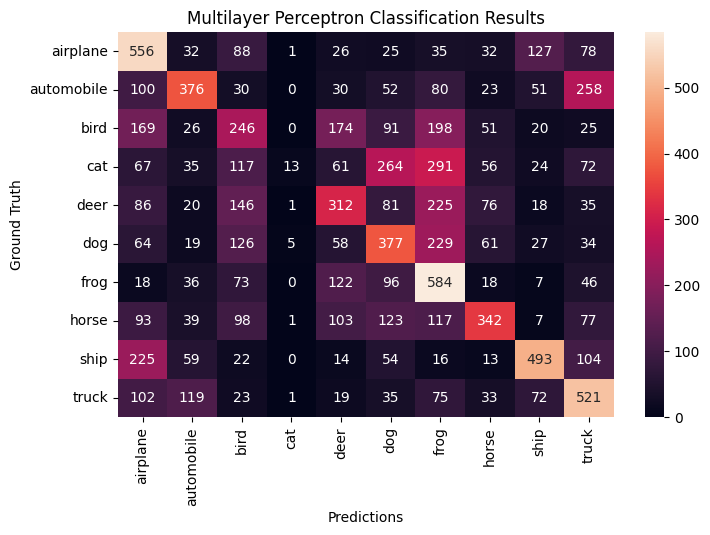

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = np.zeros(Y_test.shape)
# Get every prediction for test set.
for i in range(N_TEST):
    Y_pred[i] = clf6.predict(X_test_reduced[i])
cm = confusion_matrix(Y_test, Y_pred)

# Plot predictions and ground truth using the confusion matrix.
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predictions')
plt.ylabel('Ground Truth')
plt.title('Multilayer Perceptron Classification Results')
pass

It seems that frogs had the best classification results, followed by ariplanes, ships and trucks.  
Meanwhile, the `cat` class had overwhelmingly bad results with 1.3% accuracy.  
In general, the pictures that depict animals (`bird`, `cat`, `deer`, `dog`) suffered from misclassification to the frog class.  

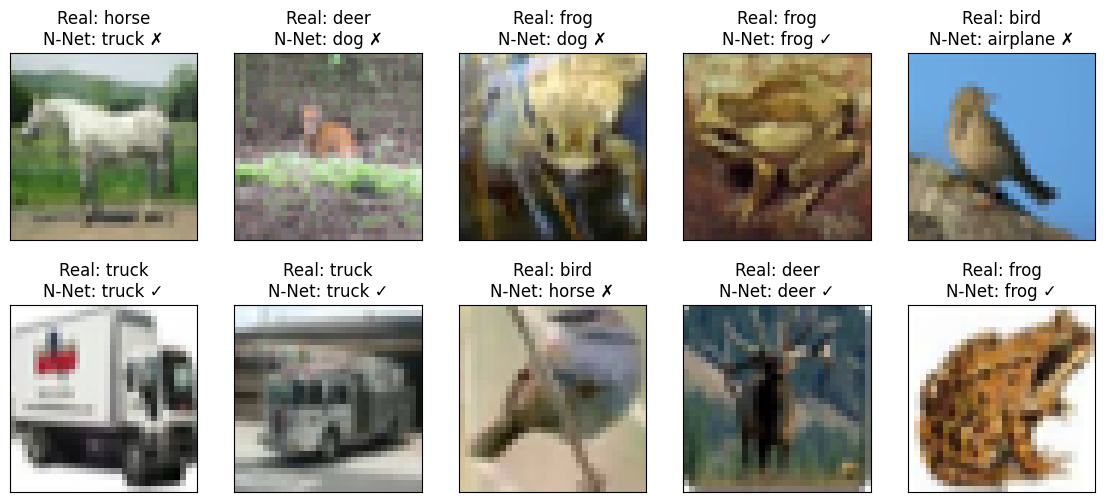

In [10]:
# Optional cell: examples of the neural network's classification decisions.
from random import sample

N_EXAMPLES = 10
index_list = sample(range(N_TEST), N_EXAMPLES)
example_objects = np.array([X_test[i] for i in index_list])
example_objects_reduced = np.array([X_test_reduced[i] for i in index_list])
real_labels = np.array([Y_test[i] for i in index_list])

# Visual hints (ignore)
check = u'\u2713'
cross = u'\u2717'

# Visualize example images
fig=plt.figure(figsize=(14, 6))
for i in range(N_EXAMPLES):
    fig.add_subplot(2, N_EXAMPLES//2, i+1)
    example_img = np.copy(example_objects[i]).reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(example_img)
    plt.xticks([])
    plt.yticks([])
    pred = clf6.predict(example_objects_reduced[i])
    plt.title(
        f"Real: {class_names[real_labels[i]]}\n"
        f"N-Net: {class_names[pred]} {check if real_labels[i] == pred else cross}"
        )
plt.show()

### Summary and comparision to sklearn's `KNearestNeighbors` and `NearestCentroid`

From the results, it is evident that `NeuralNetwork.FullyConnectedClassifier` performs very good in terms of accuracy relative to NearestCentroid.  
`sklearn.NearestCentroid` scored ~27% in accuracy and `sklearn.KNearestNeighbors` scored ~38% in accuracy.  
My Neural Network performed just as well as the latter, but a neural network should outperform these two by a large percentage in terms of classification results.  
Although, its performance is excused as:  
1. A multi-layer perceptron is not ideal for image classification. A convolutional neural network is the typical choice for image classification.  
2. `NeuralNetwork.FullyConnectedClassifier` is manually made while `sklearn.KNearestNeighbors` is a built-in class created and maintained by experienced professionals and scientists.  

A `keras.Sequential` should achieve high accuracy in the CIFAR-10 dataset (if chosen the right parameters such as depth, learning rate, layer size, layer type, activation functions etc.).